In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
from train_flow_sb import unflatten, object_from_config

In [4]:
api = wandb.Api()

In [5]:
# run = api.run('druhe/gw-src/ntnb1v04')
run = api.run('druhe/gw-src/3jm28l9h')



In [6]:
config = unflatten(run.config)

In [7]:
config['dataset']['gw_path'] = config['dataset']['path']
del config['dataset']['path']

In [8]:
dataset = object_from_config(config, key='dataset')
dataset = dataset(**config['dataset'])

In [9]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [10]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [11]:
tempdir = tempfile.TemporaryDirectory()

In [12]:
ckpt = checkpoints[-1]

In [13]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [14]:
model = object_from_config(config, key='model')

In [15]:
model = model.load_from_checkpoint(ckpt_path.name, flows=flows, dataset=dataset)




INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpzn6s00p4
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpzn6s00p4/_remote_module_non_sriptable.py


In [16]:
import hamiltorch

from torch.nn.utils import _stateless


In [17]:
def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [18]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


In [19]:
model=model.double()

params_init = hamiltorch.util.flatten(model).clone().double()


In [20]:
gw_loader = dataset.train_dataloader()

In [21]:
gw_iter = iter(gw_loader)

In [22]:
def log_prob(params, y=None):
    global gw_iter
    global sel_iter
    try:
        gw_batch = next(gw_iter)
#         sel_batch = next(sel_iter)
    except StopIteration:
        gw_iter = iter(gw_loader)
#         sel_iter = iter(sel_loader)
        gw_batch = next(gw_iter)
#         sel_batch = next(sel_iter)

    gw_batch[0] = gw_batch[0].double()
#     sel_batch[0] = sel_batch[0].double()
    
    prior = torch.distributions.Normal(params_init, 1).log_prob(params)

    params = unflatten_params(params, indices, model)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, gw_batch)    
    ll = prior.sum() / len(out) + out.mean()
#     print(out.mean().item())
    return ll




In [23]:
N = 1024
burn = 256
N_nuts = N + burn
step_size = 1e-3
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_init, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    desired_accept_rate=0.7,
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=True)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Step: 0, Current Hamiltoninian: 51.17231404526718, Proposed Hamiltoninian: 85.56736641479243
REJECT
Step: 1, Current Hamiltoninian: 49.876430770296935, Proposed Hamiltoninian: 63.78613650348716
REJECT
Step: 2, Current Hamiltoninian: 54.409592456081384, Proposed Hamiltoninian: 69.27462270083545
REJECT
Step: 3, Current Hamiltoninian: 45.41333464379116, Proposed Hamiltoninian: 45.51886465721352
Accept rho: -0.10553001342236001
Step: 4, Current Hamiltoninian: 48.34981735662185, Proposed Hamiltoninian: 48.5100934678102
Accept rho: -0.1602761111883524
Step: 5, Current Hamiltoninian: 56.50572738559153, Proposed Hamiltoninian: 57.064014634324224
REJECT
Step: 6, Current Hamiltoninian: 50.159409897140414, Proposed Hamiltoninian: 50.356672667473674
REJECT
Step: 7, Current Hamiltoninian: 54.16365451587101, Proposed Hamiltoninian: 54.25276141088993
Accept rho: -0.08910689501892222


Step: 70, Current Hamiltoninian: 51.99278091792357, Proposed Hamiltoninian: 51.24738043211019
Accept rho: 0.0
Step: 71, Current Hamiltoninian: 80.8975856309161, Proposed Hamiltoninian: 82.1611409669101
Accept rho: -1.263555335993999
Step: 72, Current Hamiltoninian: 55.98570549856041, Proposed Hamiltoninian: 55.97161359233314
Accept rho: 0.0
Step: 73, Current Hamiltoninian: 55.2649130904595, Proposed Hamiltoninian: 56.72657375792229
REJECT
Step: 74, Current Hamiltoninian: 65.45188862363091, Proposed Hamiltoninian: 64.782892671877
Accept rho: 0.0
Step: 75, Current Hamiltoninian: 47.85334440228885, Proposed Hamiltoninian: 48.17234436446809
REJECT
Step: 76, Current Hamiltoninian: 55.72510479012676, Proposed Hamiltoninian: 57.5522104477103
REJECT
Step: 77, Current Hamiltoninian: 56.63259138482935, Proposed Hamiltoninian: 56.56022012961718
Accept rho: 0.0
Step: 78, Current Hamiltoninian: 60.18025617191625, Proposed Hamiltoninian: 60.039101383981446
Accept rho: 0.0
Step: 79, Current Hamiltoni

Step: 142, Current Hamiltoninian: 52.078887348486404, Proposed Hamiltoninian: 50.28647664458758
Accept rho: 0.0
Step: 143, Current Hamiltoninian: 52.972377419054354, Proposed Hamiltoninian: 52.85380246258886
Accept rho: 0.0
Step: 144, Current Hamiltoninian: 56.709964305417905, Proposed Hamiltoninian: 57.29428722615632
REJECT
Step: 145, Current Hamiltoninian: 46.61175055099562, Proposed Hamiltoninian: 47.89848407201122
REJECT
Step: 146, Current Hamiltoninian: 53.78699921633517, Proposed Hamiltoninian: 53.76399559117903
Accept rho: 0.0
Step: 147, Current Hamiltoninian: 41.180696152331436, Proposed Hamiltoninian: 41.119898992340765
Accept rho: 0.0
Step: 148, Current Hamiltoninian: 52.330398357408114, Proposed Hamiltoninian: 54.73451758419868
REJECT
Step: 149, Current Hamiltoninian: 56.96520267314945, Proposed Hamiltoninian: 57.85451052194438
REJECT
Step: 150, Current Hamiltoninian: 51.971284100172014, Proposed Hamiltoninian: 52.57698025820593
REJECT
Step: 151, Current Hamiltoninian: 51.49

Step: 216, Current Hamiltoninian: 62.945141464804465, Proposed Hamiltoninian: 60.933332357044534
Accept rho: 0.0
Step: 217, Current Hamiltoninian: 55.78433115049345, Proposed Hamiltoninian: 55.660958278338086
Accept rho: 0.0
Step: 218, Current Hamiltoninian: 54.93591937021449, Proposed Hamiltoninian: 56.29610376283155
REJECT
Step: 219, Current Hamiltoninian: 77.55185019451473, Proposed Hamiltoninian: 75.69157006332469
Accept rho: 0.0
Step: 220, Current Hamiltoninian: 56.582587985515346, Proposed Hamiltoninian: 55.69481511522085
Accept rho: 0.0
Step: 221, Current Hamiltoninian: 57.514859015258914, Proposed Hamiltoninian: 57.70744457929675
Accept rho: -0.19258556403783444
Step: 222, Current Hamiltoninian: 62.62858926158894, Proposed Hamiltoninian: 61.51609350987566
Accept rho: 0.0
Step: 223, Current Hamiltoninian: 52.57617815895699, Proposed Hamiltoninian: 48.80893776850808
Accept rho: 0.0
Step: 224, Current Hamiltoninian: 48.17245622233693, Proposed Hamiltoninian: 50.86674951903772
REJE

Step: 288, Current Hamiltoninian: 46.55100927522225, Proposed Hamiltoninian: 46.71529537672287
Accept rho: -0.16428610150062184
Step: 289, Current Hamiltoninian: 47.291705830329114, Proposed Hamiltoninian: 47.181733939508966
Accept rho: 0.0
Step: 290, Current Hamiltoninian: 52.2277216093553, Proposed Hamiltoninian: 51.98072290622848
Accept rho: 0.0
Step: 291, Current Hamiltoninian: 62.01485928113625, Proposed Hamiltoninian: 62.027586930600606
Accept rho: -0.012727649464352453
Step: 292, Current Hamiltoninian: 55.223567327655054, Proposed Hamiltoninian: 54.71928992213529
Accept rho: 0.0
Step: 293, Current Hamiltoninian: 44.1057545065483, Proposed Hamiltoninian: 45.53989869513656
Accept rho: -1.434144188588256
Step: 294, Current Hamiltoninian: 47.98744537245939, Proposed Hamiltoninian: 48.04146722547965
Accept rho: -0.054021853020259414
Step: 295, Current Hamiltoninian: 56.00200575638606, Proposed Hamiltoninian: 55.507966685724945
Accept rho: 0.0
Step: 296, Current Hamiltoninian: 50.7899

Step: 360, Current Hamiltoninian: 48.39071337058765, Proposed Hamiltoninian: 47.84349242209621
Accept rho: 0.0
Step: 361, Current Hamiltoninian: 48.99839761834419, Proposed Hamiltoninian: 49.667286071790244
REJECT
Step: 362, Current Hamiltoninian: 60.02476421227519, Proposed Hamiltoninian: 61.03838850097408
Accept rho: -1.0136242886988924
Step: 363, Current Hamiltoninian: 57.90858949346806, Proposed Hamiltoninian: 57.594018345500885
Accept rho: 0.0
Step: 364, Current Hamiltoninian: 65.14145872240555, Proposed Hamiltoninian: 65.21300762753106
Accept rho: -0.07154890512551049
Step: 365, Current Hamiltoninian: 51.656653742812395, Proposed Hamiltoninian: 51.63281187119904
Accept rho: 0.0
Step: 366, Current Hamiltoninian: 62.202343742316295, Proposed Hamiltoninian: 61.66892745011979
Accept rho: 0.0
Step: 367, Current Hamiltoninian: 42.10151298485734, Proposed Hamiltoninian: 42.3482642060246
REJECT
Step: 368, Current Hamiltoninian: 57.300516489287084, Proposed Hamiltoninian: 56.7547532215852

Step: 431, Current Hamiltoninian: 59.3119472543234, Proposed Hamiltoninian: 60.631498927243584
REJECT
Step: 432, Current Hamiltoninian: 50.79508628114368, Proposed Hamiltoninian: 50.787063457844624
Accept rho: 0.0
Step: 433, Current Hamiltoninian: 48.33079517179792, Proposed Hamiltoninian: 48.32591598096903
Accept rho: 0.0
Step: 434, Current Hamiltoninian: 55.0505905589022, Proposed Hamiltoninian: 58.27932671691563
REJECT
Step: 435, Current Hamiltoninian: 54.579977632541784, Proposed Hamiltoninian: 54.08854725033864
Accept rho: 0.0
Step: 436, Current Hamiltoninian: 55.75429440210496, Proposed Hamiltoninian: 56.4669187790611
REJECT
Step: 437, Current Hamiltoninian: 41.68600659228936, Proposed Hamiltoninian: 41.31284725878627
Accept rho: 0.0
Step: 438, Current Hamiltoninian: 51.8428812893996, Proposed Hamiltoninian: 51.853872432437356
Accept rho: -0.010991143037756501
Step: 439, Current Hamiltoninian: 60.379081377586715, Proposed Hamiltoninian: 60.15365341299797
Accept rho: 0.0
Step: 440

Step: 502, Current Hamiltoninian: 51.21191276351188, Proposed Hamiltoninian: 51.24030509761812
REJECT
Step: 503, Current Hamiltoninian: 54.86552603978927, Proposed Hamiltoninian: 54.1931334099614
Accept rho: 0.0
Step: 504, Current Hamiltoninian: 61.73648785648784, Proposed Hamiltoninian: 61.23408159865723
Accept rho: 0.0
Step: 505, Current Hamiltoninian: 55.22369053905807, Proposed Hamiltoninian: 55.77364940481465
Accept rho: -0.5499588657565795
Step: 506, Current Hamiltoninian: 53.38744491664058, Proposed Hamiltoninian: 54.16080416712245
REJECT
Step: 507, Current Hamiltoninian: 49.197280643820335, Proposed Hamiltoninian: 49.47175168678982
REJECT
Step: 508, Current Hamiltoninian: 54.51836762620913, Proposed Hamiltoninian: 53.82177317254374
Accept rho: 0.0
Step: 509, Current Hamiltoninian: 55.523728578703604, Proposed Hamiltoninian: 55.4263456681698
Accept rho: 0.0
Step: 510, Current Hamiltoninian: 57.855632547649655, Proposed Hamiltoninian: 58.78121100630429
Accept rho: -0.925578458654

Step: 573, Current Hamiltoninian: 65.76699623972485, Proposed Hamiltoninian: 64.90173901244363
Accept rho: 0.0
Step: 574, Current Hamiltoninian: 45.64597553828134, Proposed Hamiltoninian: 44.71327335821583
Accept rho: 0.0
Step: 575, Current Hamiltoninian: 52.456085210808695, Proposed Hamiltoninian: 52.5018777307418
Accept rho: -0.04579251993310862
Step: 576, Current Hamiltoninian: 50.71768551647493, Proposed Hamiltoninian: 50.457311940278
Accept rho: 0.0
Step: 577, Current Hamiltoninian: 49.75377507861614, Proposed Hamiltoninian: 50.40185756951281
REJECT
Step: 578, Current Hamiltoninian: 55.66954281756546, Proposed Hamiltoninian: 55.158597585640564
Accept rho: 0.0
Step: 579, Current Hamiltoninian: 60.10394937745846, Proposed Hamiltoninian: 60.320302722574375
REJECT
Step: 580, Current Hamiltoninian: 57.466911838049924, Proposed Hamiltoninian: 57.324233629939826
Accept rho: 0.0
Step: 581, Current Hamiltoninian: 67.75773428161784, Proposed Hamiltoninian: 68.05666496300306
REJECT
Step: 582

Step: 644, Current Hamiltoninian: 59.50152619058296, Proposed Hamiltoninian: 60.58938562850648
Accept rho: -1.0878594379235196
Step: 645, Current Hamiltoninian: 54.70277178215997, Proposed Hamiltoninian: 54.62131568112716
Accept rho: 0.0
Step: 646, Current Hamiltoninian: 46.643143878474845, Proposed Hamiltoninian: 46.1657281621761
Accept rho: 0.0
Step: 647, Current Hamiltoninian: 44.65431315220668, Proposed Hamiltoninian: 44.52495186112288
Accept rho: 0.0
Step: 648, Current Hamiltoninian: 43.78892868632151, Proposed Hamiltoninian: 43.65274320155061
Accept rho: 0.0
Step: 649, Current Hamiltoninian: 55.50028887193774, Proposed Hamiltoninian: 55.24354422130901
Accept rho: 0.0
Step: 650, Current Hamiltoninian: 54.54455142715116, Proposed Hamiltoninian: 54.17948144191986
Accept rho: 0.0
Step: 651, Current Hamiltoninian: 58.18648151044059, Proposed Hamiltoninian: 58.234024733804816
Accept rho: -0.04754322336422234
Step: 652, Current Hamiltoninian: 62.62779804924488, Proposed Hamiltoninian: 6

Step: 715, Current Hamiltoninian: 62.07922323700241, Proposed Hamiltoninian: 62.29637516938793
Accept rho: -0.21715193238551933
Step: 716, Current Hamiltoninian: 54.113733514549445, Proposed Hamiltoninian: 53.53554846743801
Accept rho: 0.0
Step: 717, Current Hamiltoninian: 50.99031727667375, Proposed Hamiltoninian: 52.24380998685702
Accept rho: -1.2534927101832736
Step: 718, Current Hamiltoninian: 53.53805007927457, Proposed Hamiltoninian: 53.74788822607397
Accept rho: -0.20983814679939883
Step: 719, Current Hamiltoninian: 57.575700206355336, Proposed Hamiltoninian: 57.88072031318397
Accept rho: -0.30502010682863556
Step: 720, Current Hamiltoninian: 62.52876441017834, Proposed Hamiltoninian: 62.83020643041137
Accept rho: -0.3014420202330328
Step: 721, Current Hamiltoninian: 50.91406346897038, Proposed Hamiltoninian: 51.49172027503461
REJECT
Step: 722, Current Hamiltoninian: 44.80015218614058, Proposed Hamiltoninian: 44.61954826751086
Accept rho: 0.0
Step: 723, Current Hamiltoninian: 48

Step: 784, Current Hamiltoninian: 60.736906766091735, Proposed Hamiltoninian: 60.87258948752142
Accept rho: -0.1356827214296814
Step: 785, Current Hamiltoninian: 56.62847704866691, Proposed Hamiltoninian: 55.22248328933214
Accept rho: 0.0
Step: 786, Current Hamiltoninian: 53.61399615207225, Proposed Hamiltoninian: 53.71445665035871
Accept rho: -0.1004604982864663
Step: 787, Current Hamiltoninian: 75.15797728343621, Proposed Hamiltoninian: 74.82563418154191
Accept rho: 0.0
Step: 788, Current Hamiltoninian: 54.7398703531212, Proposed Hamiltoninian: 55.02154930664254
Accept rho: -0.2816789535213431
Step: 789, Current Hamiltoninian: 47.66754205768318, Proposed Hamiltoninian: 48.176781202392824
REJECT
Step: 790, Current Hamiltoninian: 61.027100259694976, Proposed Hamiltoninian: 61.083252293236654
Accept rho: -0.05615203354167875
Step: 791, Current Hamiltoninian: 54.60081732487207, Proposed Hamiltoninian: 54.277454630763145
Accept rho: 0.0
Step: 792, Current Hamiltoninian: 59.05103669195771,

Step: 855, Current Hamiltoninian: 60.356116171945594, Proposed Hamiltoninian: 59.91050151724736
Accept rho: 0.0
Step: 856, Current Hamiltoninian: 55.562001416814155, Proposed Hamiltoninian: 55.74023305956815
Accept rho: -0.1782316427539925
Step: 857, Current Hamiltoninian: 63.75666210198316, Proposed Hamiltoninian: 63.72914795790432
Accept rho: 0.0
Step: 858, Current Hamiltoninian: 62.507468118120684, Proposed Hamiltoninian: 62.69989475146659
Accept rho: -0.19242663334590304
Step: 859, Current Hamiltoninian: 50.86126466160457, Proposed Hamiltoninian: 50.54418262828342
Accept rho: 0.0
Step: 860, Current Hamiltoninian: 46.492628310257174, Proposed Hamiltoninian: 46.37074605309913
Accept rho: 0.0
Step: 861, Current Hamiltoninian: 42.95534181046509, Proposed Hamiltoninian: 42.602905579173814
Accept rho: 0.0
Step: 862, Current Hamiltoninian: 68.41007593171467, Proposed Hamiltoninian: 69.14371507057696
Accept rho: -0.7336391388622872
Step: 863, Current Hamiltoninian: 55.171550606594096, Prop

Step: 925, Current Hamiltoninian: 46.48208246378107, Proposed Hamiltoninian: 46.989176712495066
Accept rho: -0.5070942487139973
Step: 926, Current Hamiltoninian: 52.337757098237496, Proposed Hamiltoninian: 52.289119220291454
Accept rho: 0.0
Step: 927, Current Hamiltoninian: 57.18125918804809, Proposed Hamiltoninian: 57.04893364753595
Accept rho: 0.0
Step: 928, Current Hamiltoninian: 49.024609123156935, Proposed Hamiltoninian: 49.18533756689858
Accept rho: -0.16072844374164674
Step: 929, Current Hamiltoninian: 51.46617813188887, Proposed Hamiltoninian: 51.11954778631965
Accept rho: 0.0
Step: 930, Current Hamiltoninian: 54.86707567791638, Proposed Hamiltoninian: 55.265944174855555
Accept rho: -0.3988684969391727
Step: 931, Current Hamiltoninian: 57.3273105645639, Proposed Hamiltoninian: 56.69655153150725
Accept rho: 0.0
Step: 932, Current Hamiltoninian: 61.932935044290545, Proposed Hamiltoninian: 60.28962659277392
Accept rho: 0.0
Step: 933, Current Hamiltoninian: 56.65207817666885, Propo

Step: 996, Current Hamiltoninian: 60.856836949646386, Proposed Hamiltoninian: 60.47741171057904
Accept rho: 0.0
Step: 997, Current Hamiltoninian: 53.05375924440443, Proposed Hamiltoninian: 53.01212222809988
Accept rho: 0.0
Step: 998, Current Hamiltoninian: 55.199766830737985, Proposed Hamiltoninian: 55.15532682793126
Accept rho: 0.0
Step: 999, Current Hamiltoninian: 64.7370122904947, Proposed Hamiltoninian: 66.60744515177201
REJECT
Step: 1000, Current Hamiltoninian: 49.867755110880694, Proposed Hamiltoninian: 50.275858762218824
Accept rho: -0.40810365133813065
Step: 1001, Current Hamiltoninian: 59.545436276435126, Proposed Hamiltoninian: 58.48206888258781
Accept rho: 0.0
Step: 1002, Current Hamiltoninian: 51.83122773211144, Proposed Hamiltoninian: 52.40437545754671
Accept rho: -0.5731477254352768
Step: 1003, Current Hamiltoninian: 45.760080123717685, Proposed Hamiltoninian: 45.550324681864154
Accept rho: 0.0
Step: 1004, Current Hamiltoninian: 42.77800787324103, Proposed Hamiltoninian: 

Step: 1068, Current Hamiltoninian: 62.45603522524851, Proposed Hamiltoninian: 51.84233356159702
Accept rho: 0.0
Step: 1069, Current Hamiltoninian: 66.2874324582625, Proposed Hamiltoninian: 66.50996104946532
Accept rho: -0.22252859120281698
Step: 1070, Current Hamiltoninian: 57.00274524539715, Proposed Hamiltoninian: 56.22068216777001
Accept rho: 0.0
Step: 1071, Current Hamiltoninian: 64.64072781105526, Proposed Hamiltoninian: 62.79371129976132
Accept rho: 0.0
Step: 1072, Current Hamiltoninian: 54.3858446647914, Proposed Hamiltoninian: 55.572644498221614
REJECT
Step: 1073, Current Hamiltoninian: 55.89573585490068, Proposed Hamiltoninian: 65.10048572753058
REJECT
Step: 1074, Current Hamiltoninian: 59.317076722495734, Proposed Hamiltoninian: 60.05334560146863
REJECT
Step: 1075, Current Hamiltoninian: 47.3272323369374, Proposed Hamiltoninian: 49.63991873195519
REJECT
Step: 1076, Current Hamiltoninian: 56.26560171932483, Proposed Hamiltoninian: 58.03210841174835
REJECT
Step: 1077, Current H

Step: 1140, Current Hamiltoninian: 68.01698466817273, Proposed Hamiltoninian: 65.27035869314078
Accept rho: 0.0
Step: 1141, Current Hamiltoninian: 64.909337563732, Proposed Hamiltoninian: 64.91112782310965
Accept rho: -0.0017902593776568665
Step: 1142, Current Hamiltoninian: 57.05955237123771, Proposed Hamiltoninian: 58.00242604148671
Accept rho: -0.9428736702489999
Step: 1143, Current Hamiltoninian: 41.3212706474626, Proposed Hamiltoninian: 38.82601544549531
Accept rho: 0.0
Step: 1144, Current Hamiltoninian: 49.74237016980142, Proposed Hamiltoninian: 49.6391760182001
Accept rho: 0.0
Step: 1145, Current Hamiltoninian: 56.75122064391136, Proposed Hamiltoninian: 54.069359396973816
Accept rho: 0.0
Step: 1146, Current Hamiltoninian: 51.62885988290488, Proposed Hamiltoninian: 50.80875968283253
Accept rho: 0.0
Step: 1147, Current Hamiltoninian: 63.4366201162711, Proposed Hamiltoninian: 63.574878592329114
Accept rho: -0.138258476058013
Step: 1148, Current Hamiltoninian: 68.18093641720704, Pro

Step: 1212, Current Hamiltoninian: 54.06376136236097, Proposed Hamiltoninian: 53.97635332177286
Accept rho: 0.0
Step: 1213, Current Hamiltoninian: 57.78412936306879, Proposed Hamiltoninian: 56.62003335000903
Accept rho: 0.0
Step: 1214, Current Hamiltoninian: 53.08072461876525, Proposed Hamiltoninian: 50.31322271596404
Accept rho: 0.0
Step: 1215, Current Hamiltoninian: 58.71429590247144, Proposed Hamiltoninian: 56.28422589522421
Accept rho: 0.0
Step: 1216, Current Hamiltoninian: 50.0498056620334, Proposed Hamiltoninian: 49.89796187505843
Accept rho: 0.0
Step: 1217, Current Hamiltoninian: 53.00700466526049, Proposed Hamiltoninian: 52.43270680151236
Accept rho: 0.0
Step: 1218, Current Hamiltoninian: 60.13047774207584, Proposed Hamiltoninian: 59.156580017207034
Accept rho: 0.0
Step: 1219, Current Hamiltoninian: 50.60692515025275, Proposed Hamiltoninian: 50.765862197635485
Accept rho: -0.15893704738273584
Step: 1220, Current Hamiltoninian: 45.88603242821649, Proposed Hamiltoninian: 44.86923

In [24]:
samples = torch.stack(samples)

In [25]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

d = dataset.dimensionality
m1, m2, z, chi = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(d, -1)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z, chi], axis=-1)
input = torch.from_numpy(input)

In [26]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [27]:
with torch.no_grad():
    logprob = functional_call(model, params_init)
prob = logprob.exp().view(*resolutions)


In [28]:
pm1m2 = prob.sum((2, 3))

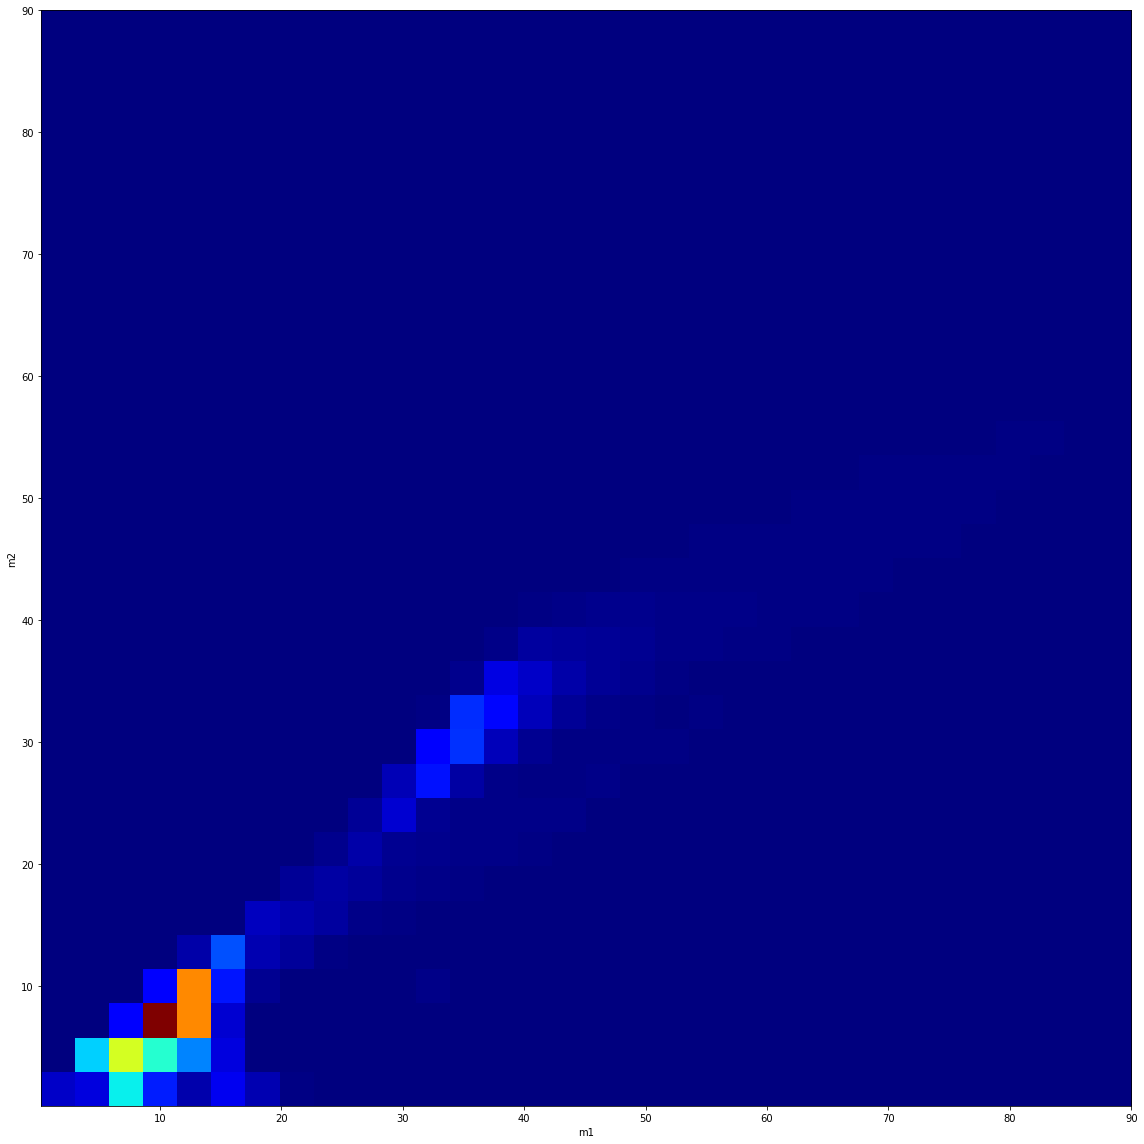

In [29]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[0][0],
        axes[0][-1],
        axes[1][0],
        axes[1][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[0])  # origin='lower' changes the order
plt.ylabel(axes_names[1])
plt.tight_layout()

In [30]:
import tqdm

In [31]:
probs = []
for sample in tqdm.tqdm(samples):
    with torch.no_grad():
        logprob = functional_call(model, sample)
    prob = logprob.exp().view(*resolutions)
    probs.append(prob)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [08:49<00:00,  1.93it/s]


In [32]:
probs = torch.stack(probs)

In [33]:
probs.shape

torch.Size([1024, 32, 32, 32, 32])

In [34]:
m1 = probs.sum((2, 3, 4)).numpy()

In [35]:
m1_med = np.median(m1, axis=0)

In [36]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

(1e-05, 3)

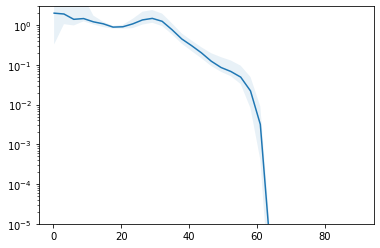

In [37]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))